In [9]:
import math as m
import numpy as np
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from copy import deepcopy
import time

In [23]:
class Sparrow:
    def __init__(
        self, 
        u: List[float], 
        f: float
             ):
        self.u = u
        self.f = f
        
class SparrowSwarm:
    def __init__(
        self,
        swarm_size: int,
        dim: int,
        m_capacity: float,
        max_loop_number: float,
        search_time: float,
        fragment: float,
        intensity_process: float,
        leader_step: float,
        reduction: float,
        recovery: float,
        levi_parameter: float,
        c1: float,
        c2: float,
        c3: float,
        min_area: float,
        func_num: int,
                 ):
        self.swarm_size = swarm_size
        self.dim = dim
        self.u_dim = dim-1
        self.m_capacity = m_capacity
        self.max_loop_number = max_loop_number
        self.search_time = search_time
        self.fragment = fragment
        self.step_integration = search_time / fragment
        self.intensity_process = intensity_process
        self.leader_step = leader_step
        self.reduction = reduction
        self.recovery = recovery
        self.levi_parameter = levi_parameter
        self.area_radius = 0
        self.c1 = c1
        self.c2 = c2
        self.c3 = c3
        self.min_area = min_area
        self.rk = 1
        
        
        self.current_iter = 0
        
        self.exact = 0
        self.function_name = ''
        self.func_num = func_num
        
        self.population = []
        self.memory = []
        self.pool = []
        self.vector_f = []
        self.vector_sigma = []
        self.best_all_iters = []
        self.best_leaders = []
        self.best_local = []

        self.euclid_list = []
        self.area_new = []
        
        self.best_x1 = []
        self.best_x2 = []
        

        
    def init_area(self, control):
        self.area = [np.array([0, 1]) for i in range(self.u_dim)] # было N_step - 1 вместо u.dim
        self.area_new = deepcopy(self.area)
        self.exact = control.ExactI()

        
        
    def form_first_pop(self, control):
        self.population.clear()
        coordinate1 = [0.8780003130169809, 0.8723049288172744, 0.8844943894933577, 0.7936686406602269, \
                      0.7382057689435966, 0.6681945834678058, 0.7049094457578333, 0.5901369326967236, \
                      0.5881334440048533, 0.6686141933926955, 0.4433165001168815, 0.4647788012764278, \
                      0.33687178262261386, 0.34709358656727574, 0.460704459644222, 0.23833714031305142, \
                      0.3787897382159562, 0.2990284485046164, 0.31016593658048563, 0.25751857086723495, \
                      0.021208355962763825, 0.039006151147497725, 0.07578778966020278, 0.0382235831834743]
        sparrow1 = Sparrow(coordinate1, 0)
        self.population.append(sparrow1)
        for i in range(self.swarm_size - 1):
            coordinate = np.array([np.random.rand() * (1 - 0) + 0 \
                          for j in range(self.u_dim)])
            #result = self.Func(coordinate)
            sparrow = Sparrow(coordinate, 0)
            self.population.append(sparrow)
            
            
    # best in abs x_j_best
    def find_best_all_iters(self, loop_id):
        if loop_id == 0:
            #self.best_all_iters.append(deepcopy(self.population)[1:])
            for i in range(1, self.swarm_size):
                self.best_all_iters.append(Sparrow(deepcopy(self.population[i].u), self.population[i].f))
                
        else:
            for i in range(1, self.swarm_size):
                if self.best_all_iters[i].f < self.population[i].f:
                    self.best_all_iters[i].f = self.population[i].f
                    self.best_all_iters[i].u = deepcopy(self.population[i].u)
        #return max(self.best_leaders, key=lambda sparrow: sparrow.f)
    
    
    # best in pop x_best
    def find_leader(self):
        return max(self.population, key=lambda sparrow: sparrow.f)
    
    
    # best local x_j_local
    def find_best_local(self, leader_index):
        self.best_local.clear()
        for i in range(self.swarm_size):
            if i != leader_index:
                sparrow = Sparrow(deepcopy(self.population[i].u), self.population[i].f)
                for j in range(self.swarm_size):
                    if i!= j:
                        if np.linalg.norm(np.array(self.population[j].u) - np.array(self.population[i].u)) <= self.area_radius:
                            if sparrow.f < self.population[j].f:
                                sparrow.u = deepcopy(self.population[j].u)
                                sparrow.f = self.population[j].f
                self.best_local.append(sparrow)
        
        
    
    def calc_f_sigma(self):
        #check the best_local - index
        self.vector_f.clear()
        self.vector_sigma.clear()
        for i in range(1, self.swarm_size):
            r1 = np.random.uniform(0, 1)
            r2 = np.random.uniform(0, 1)
            r3 = np.random.uniform(0, 1)
            numb_last = len(self.best_leaders) - 1
            best_leaders_curr = np.array(self.best_leaders[numb_last].u) - np.array(self.population[i].u)
            #best_all_iter_curr = np.array(self.best_all_iters[len(self.best_all_iters) - 1].u) - np.array(self.population[i].u)

            best_all_iter_curr = np.array(self.best_all_iters[i - 1].u) - np.array(self.population[i].u)
            
            best_loc_curr = np.array(self.best_local[i - 1].u) - np.array(self.population[i].u)
            
            tmp_f = self.c1 * r1 * best_leaders_curr
            tmp_sigma = self.c2 * r2 * best_all_iter_curr + self.c3 * r3 * best_loc_curr
            self.vector_f.append(tmp_f)
            self.vector_sigma.append(tmp_sigma)
            
            
    def new_leader_location(self, iter_id):
        sparrow = Sparrow(deepcopy(self.population[0].u), self.population[0].f)
        check_obl = 0
        devide = self.swarm_size / 2
        dev_truncated = m.trunc(devide)
        in_while = True
        
        for i in range(self.u_dim):
            while_counter = 0
            
            while (in_while):
                in_while = False
                
                rr = np.random.uniform(0, 1) * (self.area_new[i][1] - self.area_new[i][0]) + self.area_new[i][0]
                theta = rr * 2 * m.pi
                ll = m.pow(abs(rr), 1 / self.levi_parameter)
                
                if i < dev_truncated:
                    xi = ll * m.sin(theta)
                else:
                    xi = ll * m.cos(theta)
                
                check_obl = self.population[0].u[i] + (self.leader_step / (iter_id + 1)) * xi
                if check_obl < self.area_new[i][0] or check_obl > self.area_new[i][1]:
                    in_while = True
                else:
                    in_while = False
                while_counter += 1
                if while_counter > 20:
                    in_while = False
                    
            if while_counter >= 20:
                if check_obl < self.area_new[i][0]:
                    sparrow.u[i] = self.area_new[i][0]
                if check_obl > self.area_new[i][1]:
                    sparrow.u[i] = self.area_new[i][1]
            sparrow.u[i] = self.population[0].u[i] + (self.leader_step / (iter_id + 1)) * xi
            
        self.population[0].u = deepcopy(sparrow.u)
                    

    
    def new_swarm_location(self, rk):
        
        for i in range(self.u_dim):
            self.area_new[i][0] = self.population[0].u[i] - rk * (self.area[i][1] - self.area[i][0]) * 0.5
            self.area_new[i][1] = self.population[0].u[i] + rk * (self.area[i][1] - self.area[i][0]) * 0.5
            
        for i in range(self.u_dim):
            if self.area_new[i][0] < self.area[i][0]:
                self.area_new[i][0] = self.area[i][0]
            if self.area_new[i][1] > self.area[i][1]:
                self.area_new[i][1] = self.area[i][1]
        
        for i in range(self.swarm_size):
            self.population[i].u = np.array([np.random.uniform(0, 1) * \
                                   (self.area_new[j][1] - self.area_new[j][0]) + self.area_new[j][0]\
                                   for j in range(self.u_dim)])

    
    def generate_pop_from_pool(self):
        self.population.clear()
        sparrow = Sparrow(deepcopy(self.pool[0].u), self.pool[0].f)
        self.population.append(sparrow)
        
        for i in range(self.u_dim):
            self.area_new[i][0] = sparrow.u[i] - self.rk * (self.area_new[i][1] - self.area_new[i][0]) * 0.5
            self.area_new[i][1] = sparrow.u[i] + self.rk * (self.area_new[i][1] - self.area_new[i][0]) * 0.5


        #self.area_new[0][0] = sparrow.u[0] - self.rk * (self.area_new[0][1] - self.area_new[0][0]) * 0.5
        #self.area_new[0][1] = sparrow.u[0] + self.rk * (self.area_new[0][1] - self.area_new[0][0]) * 0.5
        #self.area_new[1][0] = sparrow.u[1] - self.rk * (self.area_new[1][1] - self.area_new[1][0]) * 0.5
        #self.area_new[1][1] = sparrow.u[1] + self.rk * (self.area_new[1][1] - self.area_new[1][0]) * 0.5
        
        for i in range(self.u_dim):
            if self.area_new[i][0] < self.area[i][0]:
                self.area_new[i][0] = self.area[i][0]
            if self.area_new[i][1] > self.area[i][1]:
                self.area_new[i][1] = self.area[i][1]
        
        for i in range(1, self.swarm_size):
            sparr_u = []
            for j in range(self.u_dim):
                sparr_tmp = np.random.uniform(0, 1) * (self.area_new[j][1] - self.area_new[j][0]) + self.area_new[j][0]
                if sparr_tmp < self.area_new[j][0]:
                    sparr_tmp = self.area_new[j][0]
                if sparr_tmp > self.area_new[j][1]:
                    sparr_tmp = self.area_new[j][1]
                sparr_u.append(sparr_tmp)
            sparrow = Sparrow(sparr_u, 0)
            self.population.append(sparrow)
        
    
    
    def make_step(self, i, control):
        alpha1 = np.random.uniform(0, 1)
        alpha2 = np.random.uniform(0, 1)
        alpha = np.random.uniform(0, 1)
        theta = np.random.uniform(0, 1)
        eta = (-2 * m.log(alpha1))**0.5 * m.cos(2 * m.pi * alpha2)
        
        sparr_u = []
        for j in range(self.u_dim):
            sparr_tmp = np.array(self.population[i].u[j]) + \
                        self.step_integration * self.vector_f[i-1][j] + \
                        (self.step_integration)**0.5 * self.vector_f[i-1][j] * eta
            
            if alpha < self.intensity_process * self.step_integration:
                sparr_tmp += theta
            
            # self.area_new - пустой список ВОТ ТАК
            if sparr_tmp < self.area_new[j][0]: 
                sparr_tmp = self.area_new[j][0]
            if sparr_tmp > self.area_new[j][1]:
                sparr_tmp = self.area_new[j][1]
            sparr_u.append(sparr_tmp)
        sparr_f = control.Functional(sparr_u)
        self.population[i].f = sparr_f
        self.population[i].u = deepcopy(sparr_u)
        

    
    def integration_gives_best(self, leader, control):
        best_sparrows_in_interg = []
        for i in range(1, self.swarm_size):
            best_integr = Sparrow(deepcopy(self.population[i].u), self.population[i].f)
                    
            for t in range(self.search_time):
                self.make_step(i, control)
                temp_result = control.Functional(self.population[i].u)
                if best_integr.f < temp_result:
                    best_integr.f = temp_result
                    best_integr.u = deepcopy(self.population[i].u)
                t += self.step_integration
            best_sparrows_in_interg.append(best_integr)
        best_sparrows_in_interg.append(leader)
        return best_sparrows_in_interg

    
    def work(self, control):
        start = time.monotonic()
        time.sleep(0.1)
        
        # step 1.2
        self.init_area(control)
        self.form_first_pop(control)
        
        # step 2: diffuse searching
        
        loop_id = 0
        not_first_loop = False
        while loop_id < self.max_loop_number:
            
            # step 3
            if not_first_loop:
                self.memory.clear()
                loop_id += 1
                self.rk = self.recovery
                self.area_new = deepcopy(self.area)
                self.pool.sort(reverse=True, key=lambda sparrow: sparrow.f)
                self.generate_pop_from_pool()
                
            # step 2.1
            iter_id = 0
            in_iter = True
            while in_iter:
                if iter_id != 0:
                    self.new_leader_location(iter_id)
                    self.new_swarm_location(self.rk)
                
                # step 2.2
                for i in range(self.swarm_size): 
                    coordinate = self.population[i].u
                    result = control.Functional(coordinate)
                    self.population[i].f = result
                
                # тут сортировка в порядке убывания -- от большего к меньшему
                self.population.sort(reverse=True, key=lambda sparrow: sparrow.f)
               
                # step 2.3
                leader = Sparrow(deepcopy(self.population[0].u), self.population[0].f)
                
                #self.best_leaders.append(deepcopy(self.find_leader())) # find the one leader - that's right
                self.best_leaders.append(leader)
                self.find_best_all_iters(loop_id)
                self.find_best_local(0) # the list is refilled inside the function
                
                # step 2.4
                self.calc_f_sigma()
                
                # step 2.5 + 2.6
                best_sparrs_after_integr = self.integration_gives_best(leader, control)
                
                # step 2.7
                best_sparrs_after_integr.sort(reverse=True, key=lambda sparrow: sparrow.f)
                sparrow = Sparrow(deepcopy(best_sparrs_after_integr[0].u), best_sparrs_after_integr[0].f)
                self.memory.append(sparrow)
                
                # step 2.8
                self.rk = self.reduction * self.rk
                iter_id += 1
                if iter_id >= self.m_capacity:
                    in_iter = False
                if self.rk < self.min_area:
                    in_iter = False
            
            # step 3
            self.memory.sort(reverse=True, key=lambda sparrow: sparrow.f)
            self.pool.append(Sparrow(deepcopy(self.memory[0].u), self.memory[0].f))
            if loop_id == 0:
                not_first_loop = True
        self.pool.sort(reverse=True, key=lambda sparrow: sparrow.f)
        end = time.monotonic()
        
        self.make_best_x(self.pool[0].u)
        self.draw_plots()
        #print(self.pool[0].u, self.pool[0].f,'  Presize = ', self.exact,'  Error = ', (self.exact-self.pool[0].f))
        print('Approximate', self.pool[0].f,'  Presize = ', self.exact,'  Error = ', (self.exact-self.pool[0].f))

        
        print('work time : {:>9.2f}'.format(end-start))

    
    def make_best_x(self, u):
        self.best_x1.clear()
        self.best_x2.clear()
        self.best_x1.append(0)
        self.best_x2.append(0)
        for i in range(1, self.dim):
            tmp_x1 = self.best_x2[i - 1]
            tmp_x2 = 2 * self.best_x2[i - 1] - self.best_x1[i - 1] + 1 / (self.dim**2) * u[i - 1]
            self.best_x1.append(tmp_x1)
            self.best_x2.append(tmp_x2)
        self.best_x1 = np.array(self.best_x1)
        self.best_x2 = np.array(self.best_x2)
    
    def draw_plots(self):
        plt.figure(figsize=(18, 6))

        plt.subplot(1,3,1)
        #plt.plot(self.best_list[0].u, '.')
        plt.plot(self.pool[0].u, '.')
        plt.ylabel('u')
        plt.xlabel('t')

        plt.subplot(1,3,2)
        plt.plot(self.best_x1, '.')
        plt.ylabel('$x_{1}$')
        plt.xlabel('t')

        plt.subplot(1,3,3)
        plt.plot(self.best_x2, '.')
        plt.ylabel('$x_{2}$')
        plt.xlabel('t')

        plt.show()
            

In [24]:
class DiscreteSystem:
    def __init__(
    self, 
    N_step: int,
    ):
        self.N_step = N_step # N is the dimention of the x, dim for u is the N-1
        self.u_min = 0
        self.u_max = 100

    def make_x(self, u):
        x1 = []
        x2 = []
        x1.append(0)
        x2.append(0)
        u = np.array(u)
        for i in range(1, self.N_step):
            tmp_x1 = x2[i - 1]
            tmp_x2 = 2 * x2[i - 1] - x1[i - 1] + 1 / self.N_step**2 * u[i - 1]
            x1.append(tmp_x1)
            x2.append(tmp_x2)
        x1 = np.array(x1)
        x2 = np.array(x2)
        return x1, x2

    def Functional(self, u):
        x1 = []
        x2 = []
        x1, x2 = self.make_x(u)
        x1 = np.array(x1)
        x2 = np.array(x2)
        #print(x1)
        #print(x2)
        #print('-----------------------------------')
        #print(x1[len(x1) - 1] - 1 / (2 * self.N_step) * sum(np.array(u)**2))
        return x1[len(x1) - 1] - 1 / (2 * self.N_step) * sum(np.array(u)**2)
        
        
    def ExactI(self):
        return 1/3 - (3 * self.N_step - 1) / (6 * self.N_step**2) - 1 / (2 * self.N_step**3) * sum([t**2 for t in range(self.N_step)])

In [25]:
def print_some(list_):
    for indx in range(len(list_)):
        #print('iter: ',indx, '   ', list_[indx].u, list_[indx].f)
        print(list_[indx].u, list_[indx].f)

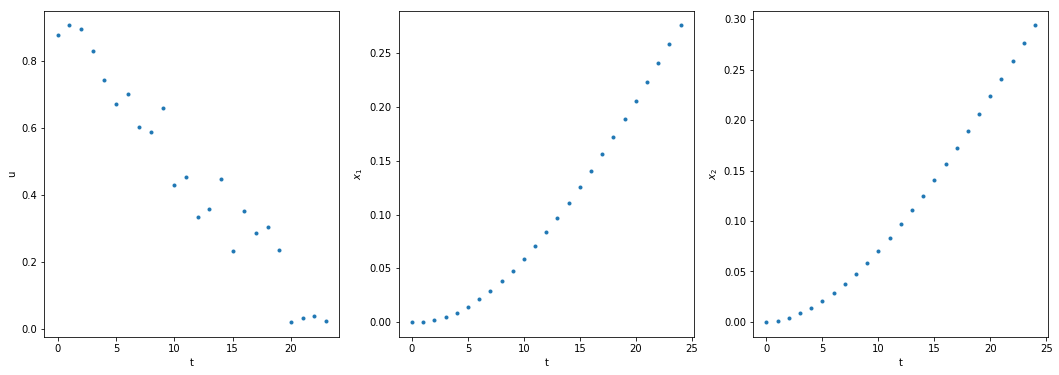

Approximate 0.13644976767125297   Presize =  0.1568   Error =  0.020350232328747025
work time :    865.36


In [32]:
a = DiscreteSystem(25)
algorithm = SparrowSwarm(250, a.N_step, 30, 25, 15, 100, 0.2, 1, 0.81, 0.89, 1.5, 0.5, 0.6, 0.5, 0.0000001, 1)
algorithm.work(a)

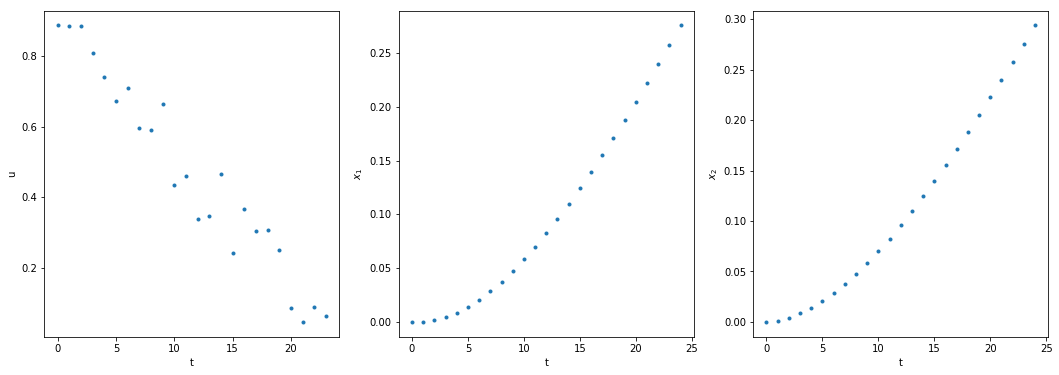

Approximate 0.13641001799251998   Presize =  0.1568   Error =  0.020389982007480018
work time :    189.87


In [30]:
a = DiscreteSystem(25)
algorithm = SparrowSwarm(150, a.N_step, 20, 15, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)
algorithm.work(a)

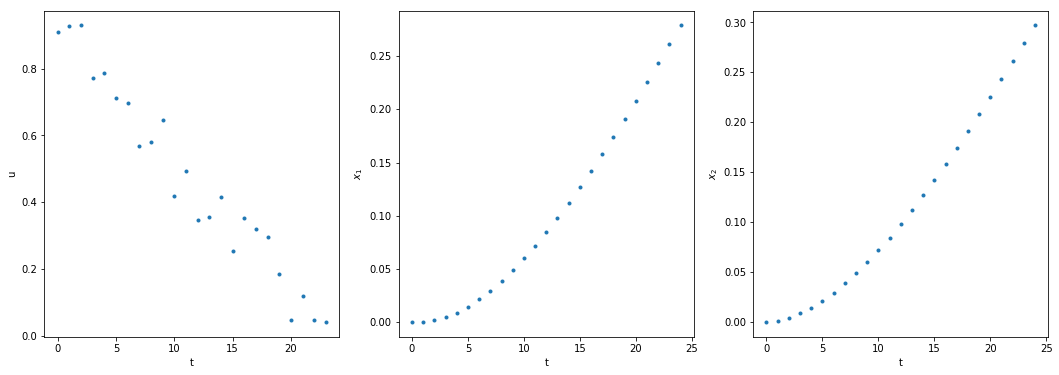

Approximate 0.1366740960649341   Presize =  0.1568   Error =  0.020125903935065886
work time :   2061.83


In [33]:
a = DiscreteSystem(25)
algorithm = SparrowSwarm(450, a.N_step, 30, 25, 15, 100, 0.2, 1, 0.81, 0.89, 1.5, 0.5, 0.6, 0.5, 0.000000001, 1)
algorithm.work(a)

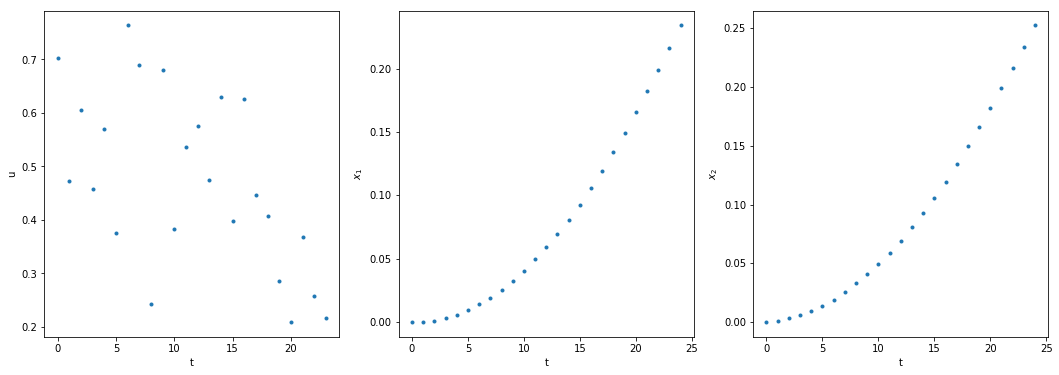

Approximate 0.11393851892692905   Presize =  0.1568   Error =  0.042861481073070945
work time :     38.59


In [98]:
a = DiscreteSystem(25)
algorithm = SparrowSwarm(35, a.N_step, 20, 15, 15, 50, 0.2, 1, 0.75, 0.89, 3, 0.5, 0.6, 0.5, 0.000001, 1)
algorithm.work(a)

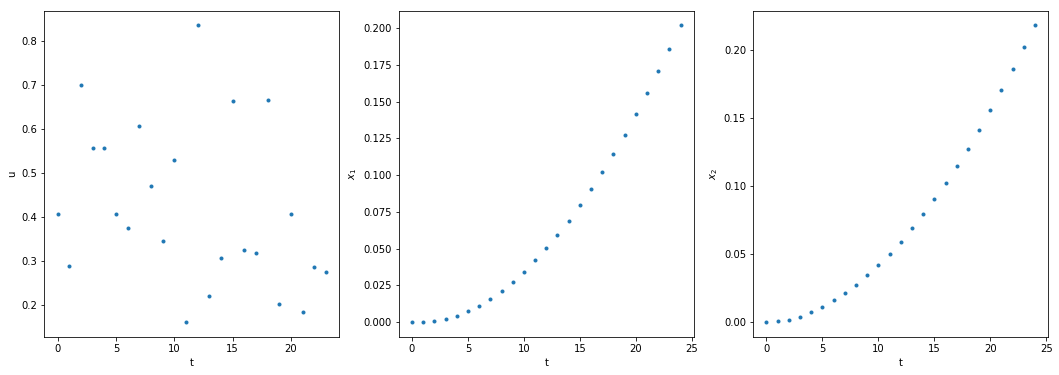

Approximate 0.10127412507185875   Presize =  0.1568   Error =  0.05552587492814125
work time :     52.74


In [100]:
a = DiscreteSystem(25)
algorithm = SparrowSwarm(40, a.N_step, 21, 16, 15, 50, 0.2, 1, 0.75, 0.89, 3, 0.5, 0.6, 0.5, 0.000001, 1)
algorithm.work(a)

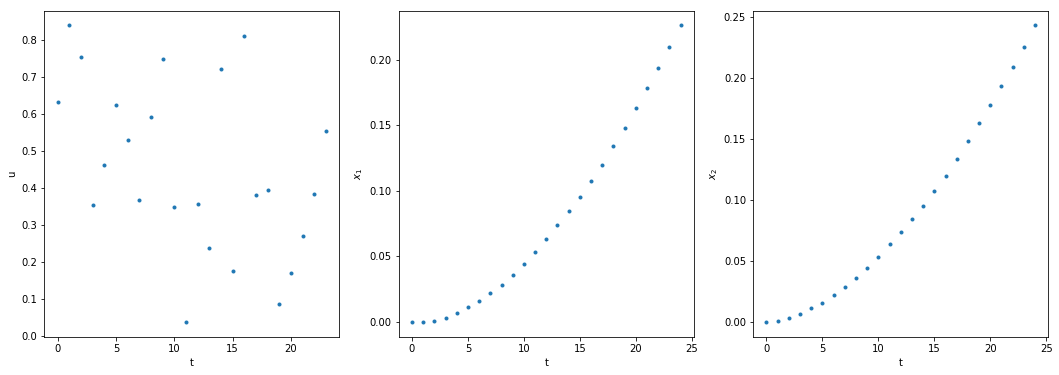

Approximate 0.10352641916192222   Presize =  0.1568   Error =  0.053273580838077775
work time :     67.99


In [101]:
a = DiscreteSystem(25)
algorithm = SparrowSwarm(40, a.N_step, 25, 16, 15, 50, 0.2, 1, 0.75, 0.89, 3, 0.5, 0.6, 0.5, 0.000001, 1)
algorithm.work(a)

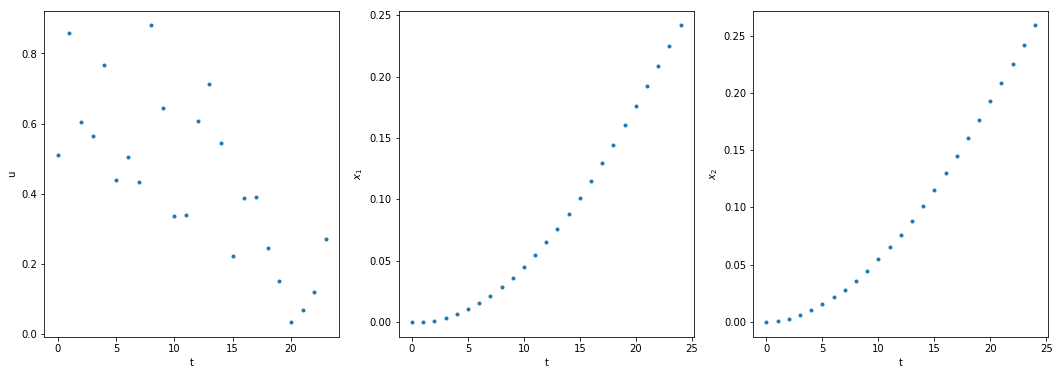

Approximate 0.12114329781952075   Presize =  0.1568   Error =  0.03565670218047924
work time :    448.63


In [109]:
a = DiscreteSystem(25)
algorithm = SparrowSwarm(80, a.N_step, 40, 35, 15, 70, 0.2, 1, 0.75, 0.89, 3, 0.5, 0.6, 0.5, 0.0000001, 1)
algorithm.work(a)

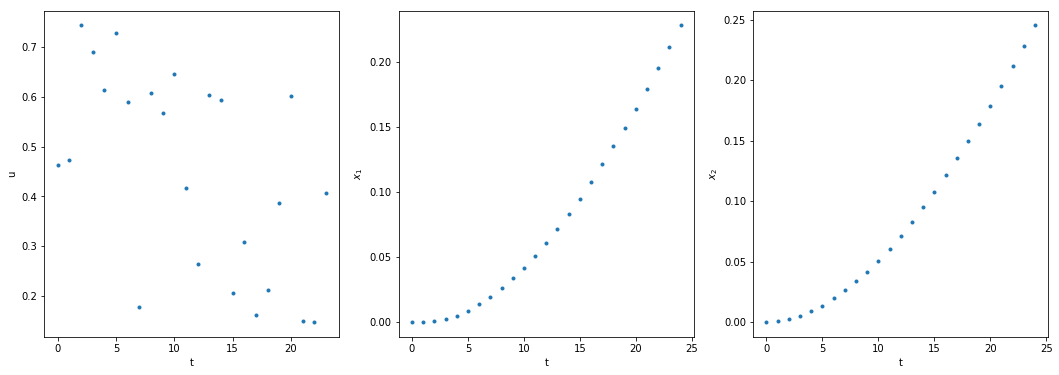

Approximate 0.1128985183669184   Presize =  0.1568   Error =  0.04390148163308159
work time :    511.59


In [111]:
a = DiscreteSystem(25)
algorithm = SparrowSwarm(80, a.N_step, 45, 35, 15, 70, 0.2, 1, 0.75, 0.89, 1.3, 0.5, 0.6, 0.5, 0.000001, 1)
algorithm.work(a)

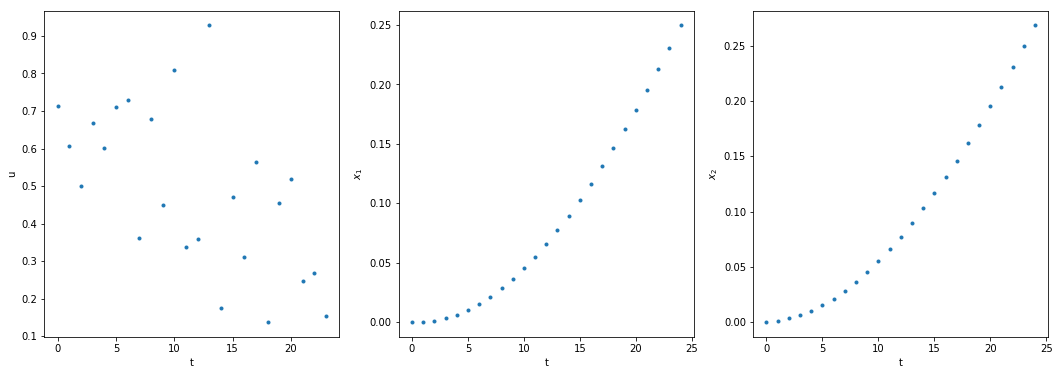

Approximate 0.11281139749569019   Presize =  0.1568   Error =  0.043988602504309804
work time :    597.34


In [112]:
a = DiscreteSystem(25)
algorithm = SparrowSwarm(90, a.N_step, 45, 35, 15, 70, 0.2, 1, 0.75, 0.89, 1.3, 0.5, 0.6, 0.5, 0.000001, 1)
algorithm.work(a)

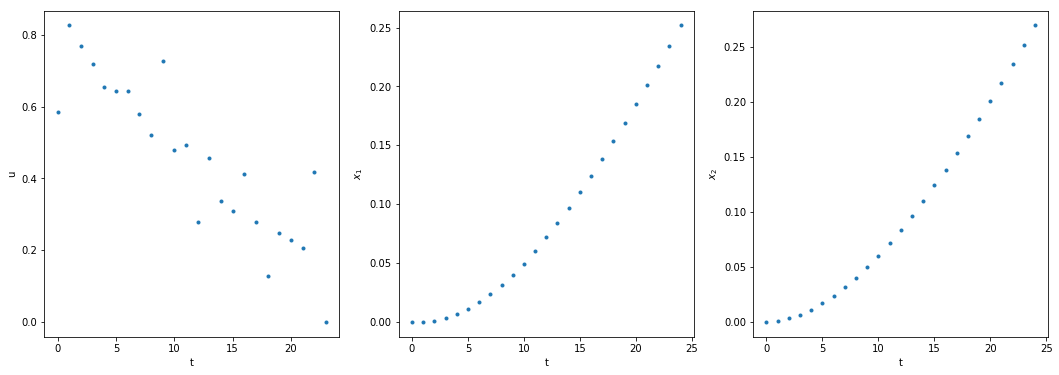

Approximate 0.1300058964274255   Presize =  0.1568   Error =  0.0267941035725745
work time :    762.02


In [113]:
a = DiscreteSystem(25)
algorithm = SparrowSwarm(120, a.N_step, 45, 35, 15, 70, 0.2, 1, 0.75, 0.89, 1.3, 0.5, 0.6, 0.5, 0.000001, 1)
algorithm.work(a)

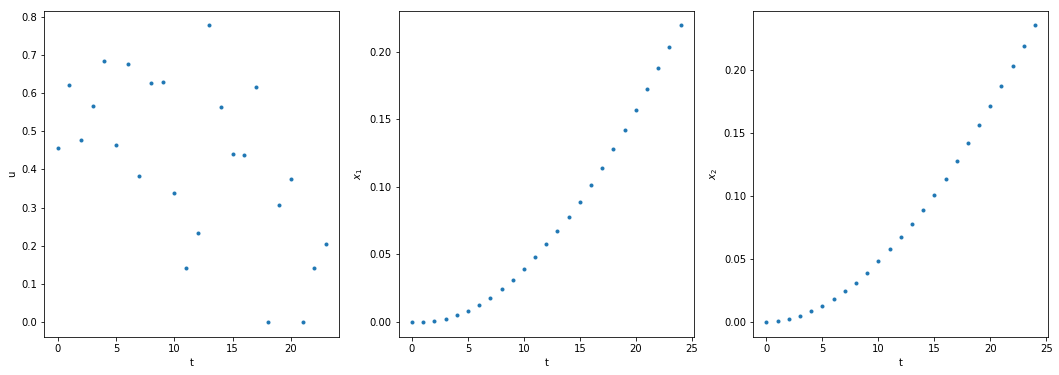

Approximate 0.11143353814323591   Presize =  0.1568   Error =  0.04536646185676409
work time :    925.66


In [115]:
a1 = DiscreteSystem(25)
algorithm1 = SparrowSwarm(130, a.N_step, 50, 35, 15, 70, 0.2, 1, 0.75, 0.89, 1.3, 0.5, 0.6, 0.5, 0.000001, 1)
algorithm1.work(a1)

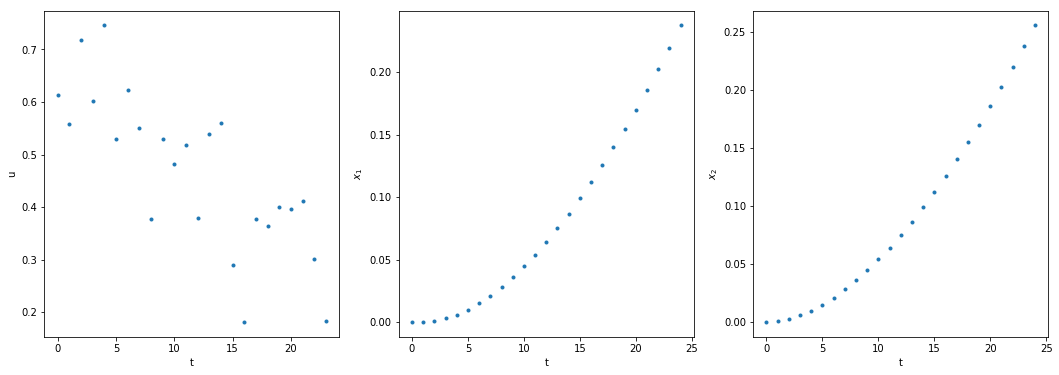

Approximate 0.1220042675968648   Presize =  0.1568   Error =  0.0347957324031352
work time :   1099.48


In [116]:
a2 = DiscreteSystem(25)
algorithm2 = SparrowSwarm(130, a.N_step, 60, 40, 15, 70, 0.2, 1, 0.75, 0.89, 1.3, 0.5, 0.6, 0.5, 0.000001, 1)
algorithm2.work(a2)

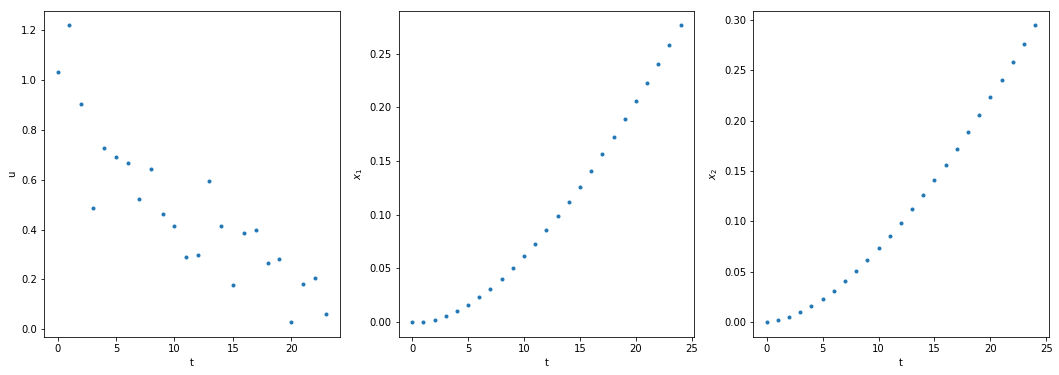

Approximate 0.12855345090351974   Presize =  0.1568   Error =  0.02824654909648025
work time :   1748.28


In [118]:
a3 = DiscreteSystem(25)
algorithm3 = SparrowSwarm(140, a.N_step, 60, 45, 15, 70, 0.2, 1, 0.81, 0.89, 1.3, 0.5, 0.6, 0.5, 0.0000001, 1)
algorithm3.work(a3)

In [16]:
def print_some(list_):
    for indx in range(algorithm.u_dim):
        print(list_.u[indx])

In [123]:
print_some(algorithm3.pool[0])

1.0313843662860327
1.2192336031424569
0.9031675020768062
0.48634358133371514
0.7267920688778853
0.6902166328054768
0.6680389049215478
0.5218306628915466
0.6448535844422977
0.46119251593594734
0.4137474660198812
0.2905209714670809
0.29782371853833833
0.5938094019564804
0.4152821684842367
0.17812234354175227
0.385538678978846
0.3974112060187931
0.2678924323671521
0.28121766266021275
0.029299308023929882
0.18196238432420664
0.20570358942077993
0.0595442837873329


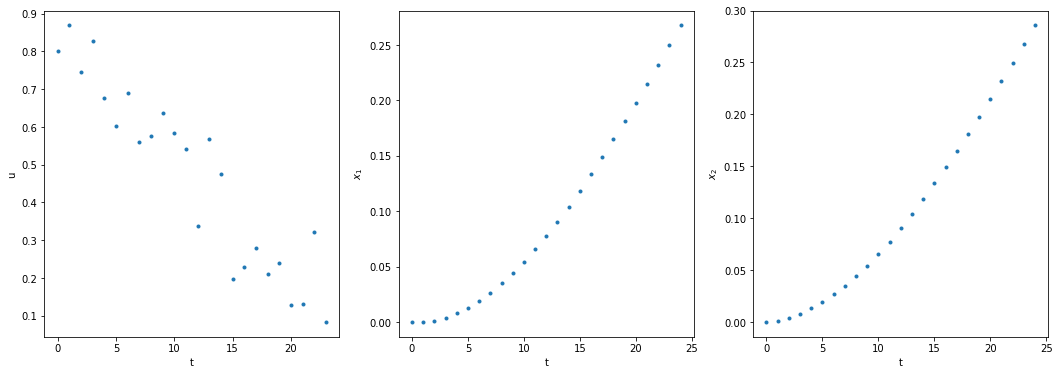

Approximate 0.13373167400128863   Presize =  0.1568   Error =  0.023068325998711364
work time :   7682.85


In [12]:
a4 = DiscreteSystem(25)
algorithm4 = SparrowSwarm(400, a4.N_step, 65, 50, 15, 70, 0.2, 1, 0.81, 0.89, 1.3, 0.5, 0.6, 0.5, 0.0000001, 1)
algorithm4.work(a4)

In [17]:
print_some(algorithm4.pool[0])

0.8008404884066418
0.8687069937654491
0.745877138747479
0.8270650706665665
0.6769276849320869
0.6025911032132907
0.6896103334941127
0.559888492766229
0.5749453219903602
0.6368308608251352
0.5844785205299652
0.5407538619558536
0.33615200118797
0.5668657927769398
0.4746110791928012
0.19700219289527765
0.2286517367123585
0.27914323366146643
0.2091036801097964
0.23989948975066389
0.12937169141215
0.130517926877943
0.32147643819225197
0.08322001426223247


In [18]:
0.02/0.1568*100

12.755102040816327

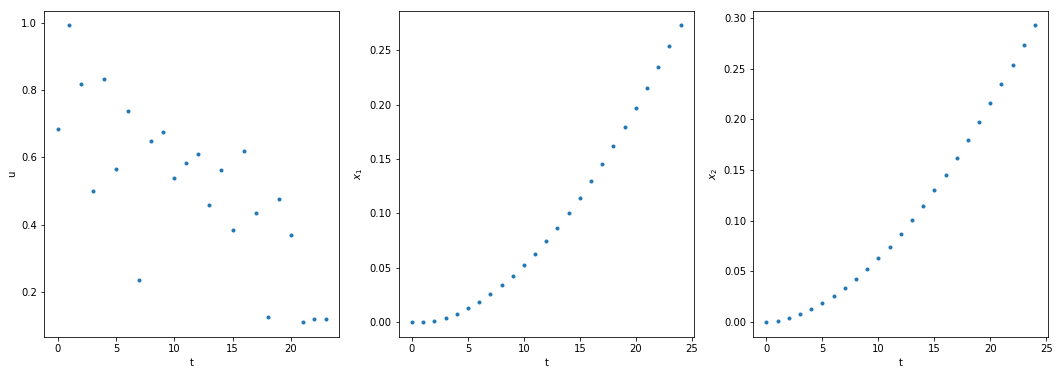

Approximate 0.122398901330493   Presize =  0.1568   Error =  0.034401098669506996
work time :    780.49


In [11]:
ab = DiscreteSystem(25)
alg = SparrowSwarm(600, ab.N_step, 15, 10, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)
alg.work(ab)

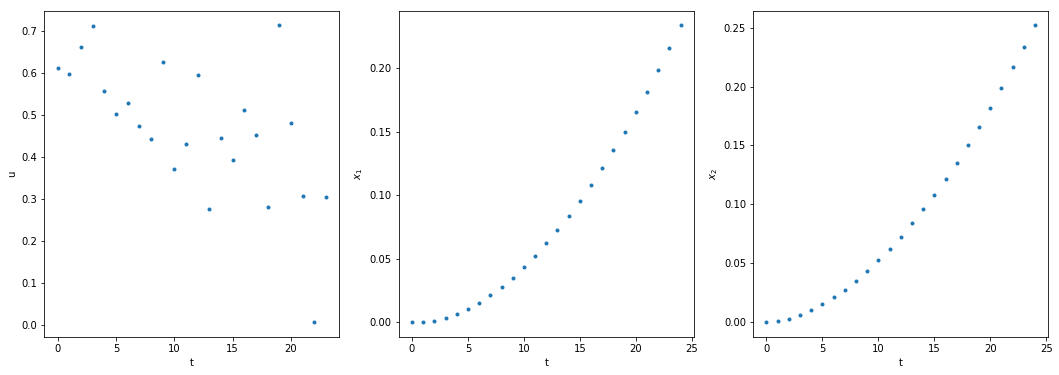

Approximate 0.11545573162927532   Presize =  0.1568   Error =  0.04134426837072468
work time :   1343.77


In [20]:
b = DiscreteSystem(25)
llg = SparrowSwarm(1200, b.N_step, 10, 10, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)
llg.work(b)

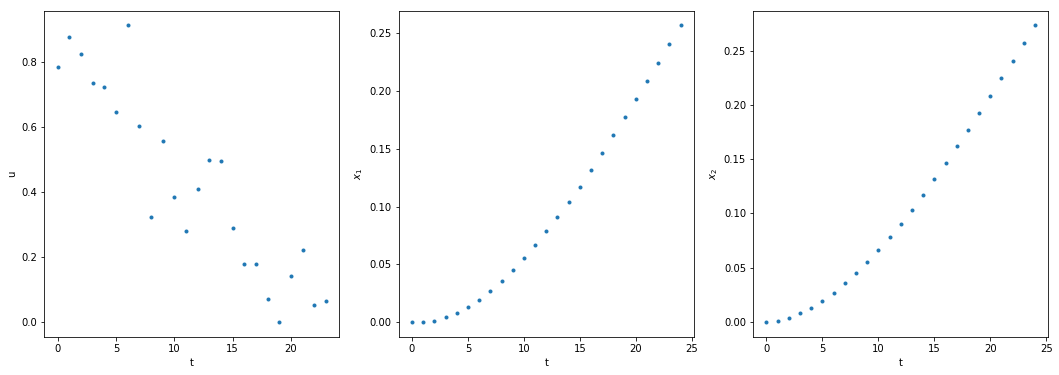

Approximate 0.1317427897918949   Presize =  0.1568   Error =  0.025057210208105085
work time :   5956.56


In [21]:
b1 = DiscreteSystem(25)
llg1 = SparrowSwarm(1500, b1.N_step, 20, 15, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)
llg1.work(b)

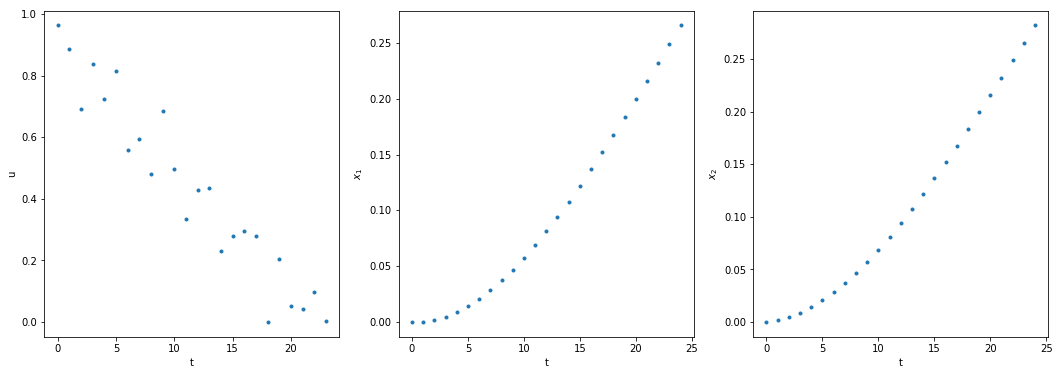

Approximate 0.13482793880512256   Presize =  0.1568   Error =  0.021972061194877435
work time :  17990.22


In [22]:
b2 = DiscreteSystem(25)
llg2 = SparrowSwarm(2500, b2.N_step, 25, 15, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)
llg2.work(b2)

In [27]:
for indx in range(llg2.u_dim):
        print(llg2.pool[0].u[indx])

0.9639683976613098
0.8876038618887354
0.6912043733994017
0.8379654888698673
0.7250897198223263
0.8149487039687581
0.5588441844131071
0.5947957161632114
0.47994813562735245
0.6848603795746708
0.496458391790237
0.33616420221680454
0.427431672044881
0.4350145251835893
0.22994153096697312
0.2811003748830819
0.296255627048606
0.2802001998642347
0
0.203531671612583
0.05070684480100007
0.04240811825275695
0.09847674648139737
0.002637780465612083


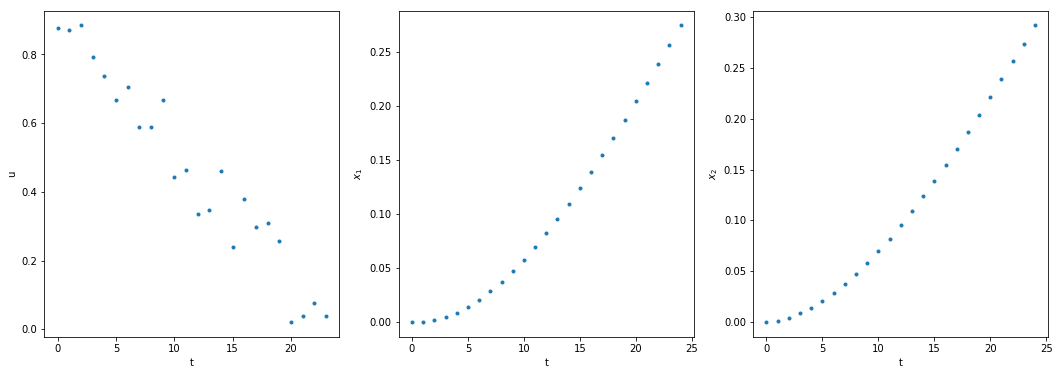

Approximate 0.13621848961453348   Presize =  0.1568   Error =  0.020581510385466517
work time :  21663.54


In [28]:
b3 = DiscreteSystem(25)
allg3 = SparrowSwarm(2000, b3.N_step, 35, 20, 15, 50, 0.2, 1, 0.81, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)
allg3.work(b3)

In [29]:
for indx in range(allg3.u_dim):
        print(allg3.pool[0].u[indx])

0.8780003130169809
0.8723049288172744
0.8844943894933577
0.7936686406602269
0.7382057689435966
0.6681945834678058
0.7049094457578333
0.5901369326967236
0.5881334440048533
0.6686141933926955
0.4433165001168815
0.4647788012764278
0.33687178262261386
0.34709358656727574
0.460704459644222
0.23833714031305142
0.3787897382159562
0.2990284485046164
0.31016593658048563
0.25751857086723495
0.021208355962763825
0.039006151147497725
0.07578778966020278
0.0382235831834743
